In [1]:
import pandas as pd

In [2]:
df=pd.read_csv('/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv', encoding='latin-1')
df.drop(df.columns[[1,2,3,4,4]], axis=1,inplace=True)
df = df.set_axis(['label', 'text'], axis=1, inplace=False)
df['label']=df['label'].replace({4: 1})
df.head()

,label,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [3]:
df['label'].value_counts()

1    800000
0    799999
Name: label, dtype: int64

In [4]:
df=pd.concat([df[df['label']==0].sample(frac=.5), df[df['label']==1].sample(frac=.5)])
# df.to_csv('data/sample.csv', index=False)
df['label'].value_counts()

0    400000
1    400000
Name: label, dtype: int64

In [5]:
from nltk.tokenize import TweetTokenizer
tokenizer=TweetTokenizer(reduce_len=True)
data=[]
for text, label in zip(df['text'].values, df['label'].values): 
    data.append((tokenizer.tokenize(text.lower()), label))
data[0]

(['@rubytears', "can't", 'dm', 'you'], 0)

(array([7.98374e+05, 1.37300e+03, 1.22000e+02, 6.10000e+01, 3.80000e+01,
        1.80000e+01, 5.00000e+00, 3.00000e+00, 4.00000e+00, 2.00000e+00]),
 array([  1. ,  36.6,  72.2, 107.8, 143.4, 179. , 214.6, 250.2, 285.8,
        321.4, 357. ]),
 <BarContainer object of 10 artists>)

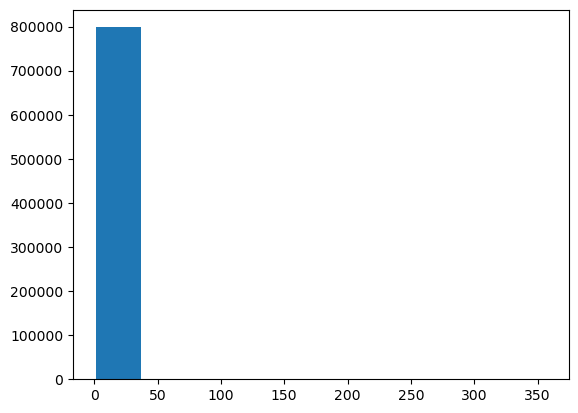

In [6]:
import matplotlib.pyplot as plt
length=[]
for text, label in data: 
    length.append(len(text))
plt.hist(length)

In [7]:
from nltk.tag import pos_tag
# pot_tags take a list of tokens
from nltk.stem import WordNetLemmatizer
lemmatizer=WordNetLemmatizer()

In [8]:
lemmatized_data=[]
for text, label in data: 
    lemmatized_tokens=[]
    for word, tag in pos_tag(text): 
        if tag.startswith('NN'): 
            pos='n'
        elif tag.startswith('VB'): 
            pos='v'
        else: 
            pos='a'
        lemmatized_tokens.append(lemmatizer.lemmatize(word, pos))
    lemmatized_data.append((lemmatized_tokens, label))
lemmatized_data[0]

(['@rubytears', "can't", 'dm', 'you'], 0)

In [9]:
from nltk.corpus import stopwords
stopwords_en=stopwords.words('english')

In [10]:
stopped_data=[]
for text, label in lemmatized_data: 
    stopped_tokens=[]
    for word in text: 
        if word not in stopwords_en: 
            stopped_tokens.append(word)
    stopped_data.append((stopped_tokens, label))
stopped_data[0]

(['@rubytears', "can't", 'dm'], 0)

In [11]:
dict_data=[]
# for text, label in stopped_data: 
for text, label in lemmatized_data: 
    dict_tokens=dict([word, True] for word in text)
    dict_data.append((dict_tokens, label))
dict_data[0]

({'@rubytears': True, "can't": True, 'dm': True, 'you': True}, 0)

In [12]:
import random
random.Random().shuffle(dict_data)
train_set=int(len(dict_data)*0.9)
X_train=dict_data[:train_set]
X_test=dict_data[train_set:]

In [13]:
from nltk import classify
from nltk import NaiveBayesClassifier
clf=NaiveBayesClassifier.train(X_train)
print(f'Train Data Accuracy: {classify.accuracy(clf, X_train)}')
print(f'Train Data Accuracy: {classify.accuracy(clf, X_test)}')
print(clf.show_most_informative_features(10))

Train Data Accuracy: 0.8460986111111111
Train Data Accuracy: 0.7659875
Most Informative Features
                  sadden = True                0 : 1      =     51.1 : 1.0
               toothache = True                0 : 1      =     43.4 : 1.0
                    sadd = True                0 : 1      =     39.7 : 1.0
                  boohoo = True                0 : 1      =     35.8 : 1.0
                  farrah = True                0 : 1      =     31.8 : 1.0
               carradine = True                0 : 1      =     31.3 : 1.0
                 uggghhh = True                0 : 1      =     30.4 : 1.0
                 mcmahon = True                0 : 1      =     30.2 : 1.0
                fuzzball = True                1 : 0      =     29.6 : 1.0
                 unloved = True                0 : 1      =     29.0 : 1.0
None


In [14]:
# train_set=int(len(stopped_data)*0.9)
# X_train=stopped_data[:train_set]
# X_test=stopped_data[train_set:]
train_set=int(len(lemmatized_data)*0.9)
X_train=lemmatized_data[:train_set]
X_test=lemmatized_data[train_set:]

In [15]:
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
tokenizer=Tokenizer()
tokenizer.fit_on_texts([text for text, label in X_train])
word_index=tokenizer.word_index

In [16]:
vocab_size=len(tokenizer.word_index)+1
print(f'Vocab Size: {vocab_size}')

Vocab Size: 407792


In [17]:
y_train=[label for text, label in X_train]
y_test=[label for text, label in X_test]
X_train=pad_sequences(tokenizer.texts_to_sequences([' '.join(text) for text, label in X_train]), maxlen=40)
X_test=pad_sequences(tokenizer.texts_to_sequences([' '.join(text) for text, label in X_test]), maxlen=40)

In [18]:
from tensorflow.keras.utils import to_categorical
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)

In [19]:
from keras.models import Sequential
from keras import layers
import time

In [20]:
current_time=time.time()
model=Sequential()
model.add(layers.Embedding(input_dim=vocab_size,output_dim=100,\
#                       input_length=30))
                      input_length=40))
model.add(layers.Bidirectional(layers.LSTM(128)))
model.add(layers.Dense(2,activation='softmax'))
model.compile(optimizer='adam',loss='categorical_crossentropy',\
              metrics=['accuracy'])

model.fit(X_train,y_train,batch_size=256,epochs=5,validation_data=(X_test,y_test))
print(f'Time to train: {time.time()-current_time}')

Epoch 1/5
2813/2813 [==============================] - 102s 33ms/step - loss: 0.4296 - accuracy: 0.8009 - val_loss: 0.4805 - val_accuracy: 0.7784
Epoch 2/5
2813/2813 [==============================] - 91s 33ms/step - loss: 0.3597 - accuracy: 0.8407 - val_loss: 0.4652 - val_accuracy: 0.7779
Epoch 3/5
2813/2813 [==============================] - 91s 33ms/step - loss: 0.3125 - accuracy: 0.8642 - val_loss: 0.5714 - val_accuracy: 0.7476
Epoch 4/5
2813/2813 [==============================] - 92s 33ms/step - loss: 0.2684 - accuracy: 0.8849 - val_loss: 0.5329 - val_accuracy: 0.7796
Epoch 5/5
2813/2813 [==============================] - 92s 33ms/step - loss: 0.2287 - accuracy: 0.9028 - val_loss: 0.5987 - val_accuracy: 0.7713
Time to train: 510.36355805397034
